# Mentor-Mentee Matching using Clustering and Cosine Similarity

**1. Import Libraries**

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

**2. Load and Preprocess Mentor Data**

In [7]:
mentor_df = pd.read_csv('mentors_database2.csv')
print(mentor_df.shape)
print(mentor_df.isnull().sum())
mentor_df = mentor_df.dropna()
print(mentor_df.shape)
mentor_df.head()

(50, 12)
Mentor_ID                         0
Mentor_Name                       0
Mentor_Email                      0
Mentor_Age                        0
Mentor_Location                   0
Mentor_YearsofOccupation          0
Mentee_Studylevel                 0
Mentor_CareerField                0
Mentor_InterestField              0
Mentor_Availabilty                0
Mentor_BurnoutRiskScore           0
Mentor_PreferredMentoringStyle    1
dtype: int64
(49, 12)


,Mentor_ID,Mentor_Name,Mentor_Email,Mentor_Age,Mentor_Location,Mentor_YearsofOccupation,Mentee_Studylevel,Mentor_CareerField,Mentor_InterestField,Mentor_Availabilty,Mentor_BurnoutRiskScore,Mentor_PreferredMentoringStyle
0,MTR0001,Sylvia Smith,sylvia.smith@guidancehub.net,50,Aarhus,10,Researcher,Engineering,Design,Weekends,7 (Low),Advisor
1,MTR0002,Jamie Lam,jamie.lam@guidancehub.net,53,Odense,12,PhD,Social Work,Politics,Weekdays,55 (Moderate),Facilitator
2,MTR0003,Philip Brown,philip.brown@example.com,36,Aarhus,12,Vocational Training,Arts,Entrepreneurship,Weekends,16 (Low),Supportive
3,MTR0004,Pamela Ho,pamela.ho@example.com,38,Copenhagen,3,High School,Engineering,AI,Weekends,33 (Low),Supportive
4,MTR0005,Melissa Carson,melissa.carson@example.com,37,Aarhus,45,Vocational Training,Arts,Sustainability,Weekends,46 (Moderate),Advisor


Convert categorical values to numerical values using one-hot encoder        
Scale Numerical Features

In [8]:

mentor_df['Mentor_BurnoutRiskScore'] = mentor_df['Mentor_BurnoutRiskScore'].str.extract(r'(\d+)').astype(float)

#Categorical features
# categorical_mentors = [
#     "Mentor_CareerField", "Mentor_InterestField",
#     "Mentor_PreferredMentoringStyle", "Mentor_Availabilty", "Mentor_Location"
# ]
categorical_mentors = ["Mentor_InterestField", "Mentor_Location"]
mentor_encoder = OneHotEncoder(sparse_output=False)
mentors_encoded = mentor_encoder.fit_transform(mentor_df[categorical_mentors])

# Numerical features
# # numerical_mentors = mentor_df[["Mentor_Age", "Mentor_YearsofOccupation", "Mentor_BurnoutRiskScore"]]
numerical_mentors = ['Mentor_BurnoutRiskScore']
numerical_mentors_scaled = StandardScaler().fit_transform(mentor_df[numerical_mentors])

X_mentors = np.hstack([numerical_mentors_scaled, mentors_encoded])


**3. Load and Preprocess Mentee Data**

In [9]:
mentee_df = pd.read_csv('mentee_database.csv', delimiter=';')
print(mentee_df.shape)
print(mentee_df.isnull().sum())
mentee_df.head()


(2000, 15)
Mentee_ID                         0
Mentee_Name                       0
Mentee_Email                      0
Mentee_Age                        0
Mentee_OccupationStatus           0
Mentee_YearsofOccupation          0
Mentee_Studylevel                 0
Mentee_CareerField                0
Mentee_InterestField              0
Mentee_StressLevel                0
Mentee_MoodTrends                 0
Mentee_SelfConfidenceLevel        0
Mentee_BurnoutRiskScore           0
Mentee_PreferredMentoringStyle    0
Mentee_Location                   0
dtype: int64


,Mentee_ID,Mentee_Name,Mentee_Email,Mentee_Age,Mentee_OccupationStatus,Mentee_YearsofOccupation,Mentee_Studylevel,Mentee_CareerField,Mentee_InterestField,Mentee_StressLevel,Mentee_MoodTrends,Mentee_SelfConfidenceLevel,Mentee_BurnoutRiskScore,Mentee_PreferredMentoringStyle,Mentee_Location
0,"1,00 MNT",Morten Kristoffersen,olivialind@example.net,35,Unemployed,0,High School,Engineering,AI,High,Negative,Medium,7 (Low),Advisor,Aarhus
1,"2,00 MNT",Hernán Barco Sanjuan,lopezjoseph@example.net,18,Unemployed,0,PhD,Social Work,Finance,High,Fluctuating,High,55 (Moderate),Facilitator,Odense
2,"3,00 MNT",Jill Lindström,marysedavid@example.org,36,Student,3,Vocational Training,Arts,Politics,Low,Fluctuating,Low,16 (Low),Supportive,Aarhus
3,"4,00 MNT",Gertrudis Cerezo Izquierdo,gsorensen@example.org,22,Unemployed,0,High School,Engineering,Sustainability,Low,Negative,High,33 (Low),Supportive,Copenhagen
4,"5,00 MNT",Emmanuelle Grenier,susanneguyot@example.org,35,Unemployed,0,Vocational Training,Arts,Politics,High,Fluctuating,Low,46 (Moderate),Advisor,Aarhus


Convert categorical values to numerical values using one-hot encoder        
Scale Numerical Features

In [10]:
mentee_df['Mentee_BurnoutRiskScore'] = mentee_df['Mentee_BurnoutRiskScore'].str.extract(r'(\d+)').astype(float)
# Encode categorical features
# categorical_mentees = [
#     "Mentee_OccupationStatus", "Mentee_Studylevel", "Mentee_CareerField",
#     "Mentee_InterestField", "Mentee_StressLevel", "Mentee_MoodTrends",
#     "Mentee_SelfConfidenceLevel", "Mentee_PreferredMentoringStyle", "Mentee_Location"
# ]

categorical_mentees = [
    "Mentee_InterestField",  "Mentee_Location"
]

mentee_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
mentees_encoded = mentee_encoder.fit_transform(mentee_df[categorical_mentees])

# Numerical features
# numerical_mentees = mentee_df[["Mentee_Age", "Mentee_YearsofOccupation", "Mentee_BurnoutRiskScore"]]
numerical_mentees = ["Mentee_BurnoutRiskScore"]
scaler = StandardScaler()
numerical_mentees_scaled = StandardScaler().fit_transform(mentee_df[numerical_mentees])
X_mentees =  np.hstack([numerical_mentees_scaled, mentees_encoded])


**4. Determine Optimal Clusters for Mentees**

k=2, Silhouette Score=0.2408
k=3, Silhouette Score=0.1856
k=4, Silhouette Score=0.2017
k=5, Silhouette Score=0.1890
k=6, Silhouette Score=0.2018
k=7, Silhouette Score=0.2273
k=8, Silhouette Score=0.2546
k=9, Silhouette Score=0.2390
k=10, Silhouette Score=0.2188
k=11, Silhouette Score=0.2271
k=12, Silhouette Score=0.2158
k=13, Silhouette Score=0.2073
k=14, Silhouette Score=0.2112
k=15, Silhouette Score=0.2172
k=16, Silhouette Score=0.2201
k=17, Silhouette Score=0.2334
k=18, Silhouette Score=0.2351
k=19, Silhouette Score=0.2546
k=20, Silhouette Score=0.2543
k=21, Silhouette Score=0.2488
k=22, Silhouette Score=0.2469
k=23, Silhouette Score=0.2578
k=24, Silhouette Score=0.2691
k=25, Silhouette Score=0.2758
k=26, Silhouette Score=0.2898
k=27, Silhouette Score=0.2994
k=28, Silhouette Score=0.3078
k=29, Silhouette Score=0.3219
k=30, Silhouette Score=0.3320
k=31, Silhouette Score=0.3430
k=32, Silhouette Score=0.3478
k=33, Silhouette Score=0.3500
k=34, Silhouette Score=0.3628
k=35, Silhouette S

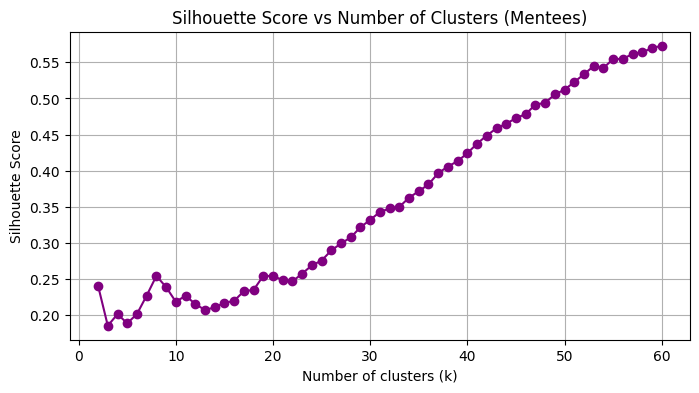

In [11]:
sil_scores = []
k_values = range(2, 61)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_mentees)
    score = silhouette_score(X_mentees, labels)
    sil_scores.append(score)
    print(f'k={k}, Silhouette Score={score:.4f}')

best_k = k_values[np.argmax(sil_scores)]
print(f"\nBest number of clusters for mentees: {best_k}")

plt.figure(figsize=(8,4))
plt.plot(k_values, sil_scores, marker='o', color='purple')
plt.title('Silhouette Score vs Number of Clusters (Mentees)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**5. Apply k-means Clustering to Mentees using the optimal number of clusters**

In [12]:
# --- Clustering Mentees ---
n_clusters = best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
mentee_df['Cluster'] = kmeans.fit_predict(X_mentees)


**6. Compute Mentee cluster Centroids & Similarity Matrix between mentors and cluster centroids**

In [13]:
cluster_centroids = []
for cluster_id in range(best_k):
    cluster_points = X_mentees[mentee_df['Cluster'] == cluster_id]
    centroid = cluster_points.mean(axis=0)
    cluster_centroids.append(centroid)

cluster_centroids = np.array(cluster_centroids)
similarity_matrix = cosine_similarity(cluster_centroids, X_mentors)


**7. Display top 5 Mentor Recommendations for each Mentee Cluster**

In [14]:

top_5_mentors_per_cluster = np.argsort(similarity_matrix, axis=1)[:, -5:][:, ::-1]
results = {}
for cluster_id in range(best_k):
    mentor_indices = top_5_mentors_per_cluster[cluster_id]
    mentor_ids = mentor_df.iloc[mentor_indices]['Mentor_ID'].values
    mentor_similarities = similarity_matrix[cluster_id, mentor_indices]
    results[cluster_id] = list(zip(mentor_ids, mentor_similarities))

for cluster_id, mentors in results.items():
    print(f"\nTop 5 mentors for Mentee Cluster {cluster_id}:")
    for mentor_id, sim_score in mentors:
        print(f"Mentor_ID: {mentor_id}, Similarity: {sim_score:.4f}")


Top 5 mentors for Mentee Cluster 0:
Mentor_ID: MTR0035, Similarity: 0.9792
Mentor_ID: MTR0042, Similarity: 0.9561
Mentor_ID: MTR0049, Similarity: 0.7947
Mentor_ID: MTR0021, Similarity: 0.6891
Mentor_ID: MTR0034, Similarity: 0.6793

Top 5 mentors for Mentee Cluster 1:
Mentor_ID: MTR0008, Similarity: 0.9930
Mentor_ID: MTR0015, Similarity: 0.8874
Mentor_ID: MTR0036, Similarity: 0.8874
Mentor_ID: MTR0048, Similarity: 0.6444
Mentor_ID: MTR0016, Similarity: 0.6444

Top 5 mentors for Mentee Cluster 2:
Mentor_ID: MTR0047, Similarity: 0.8548
Mentor_ID: MTR0005, Similarity: 0.8548
Mentor_ID: MTR0043, Similarity: 0.6676
Mentor_ID: MTR0021, Similarity: 0.6676
Mentor_ID: MTR0011, Similarity: 0.6676

Top 5 mentors for Mentee Cluster 3:
Mentor_ID: MTR0045, Similarity: 0.6389
Mentor_ID: MTR0032, Similarity: 0.6383
Mentor_ID: MTR0025, Similarity: 0.5821
Mentor_ID: MTR0040, Similarity: 0.5621
Mentor_ID: MTR0047, Similarity: 0.4392

Top 5 mentors for Mentee Cluster 4:
Mentor_ID: MTR0009, Similarity: 0.8

**8. Visualize Mentor Similarity per Cluster using Heatmap**

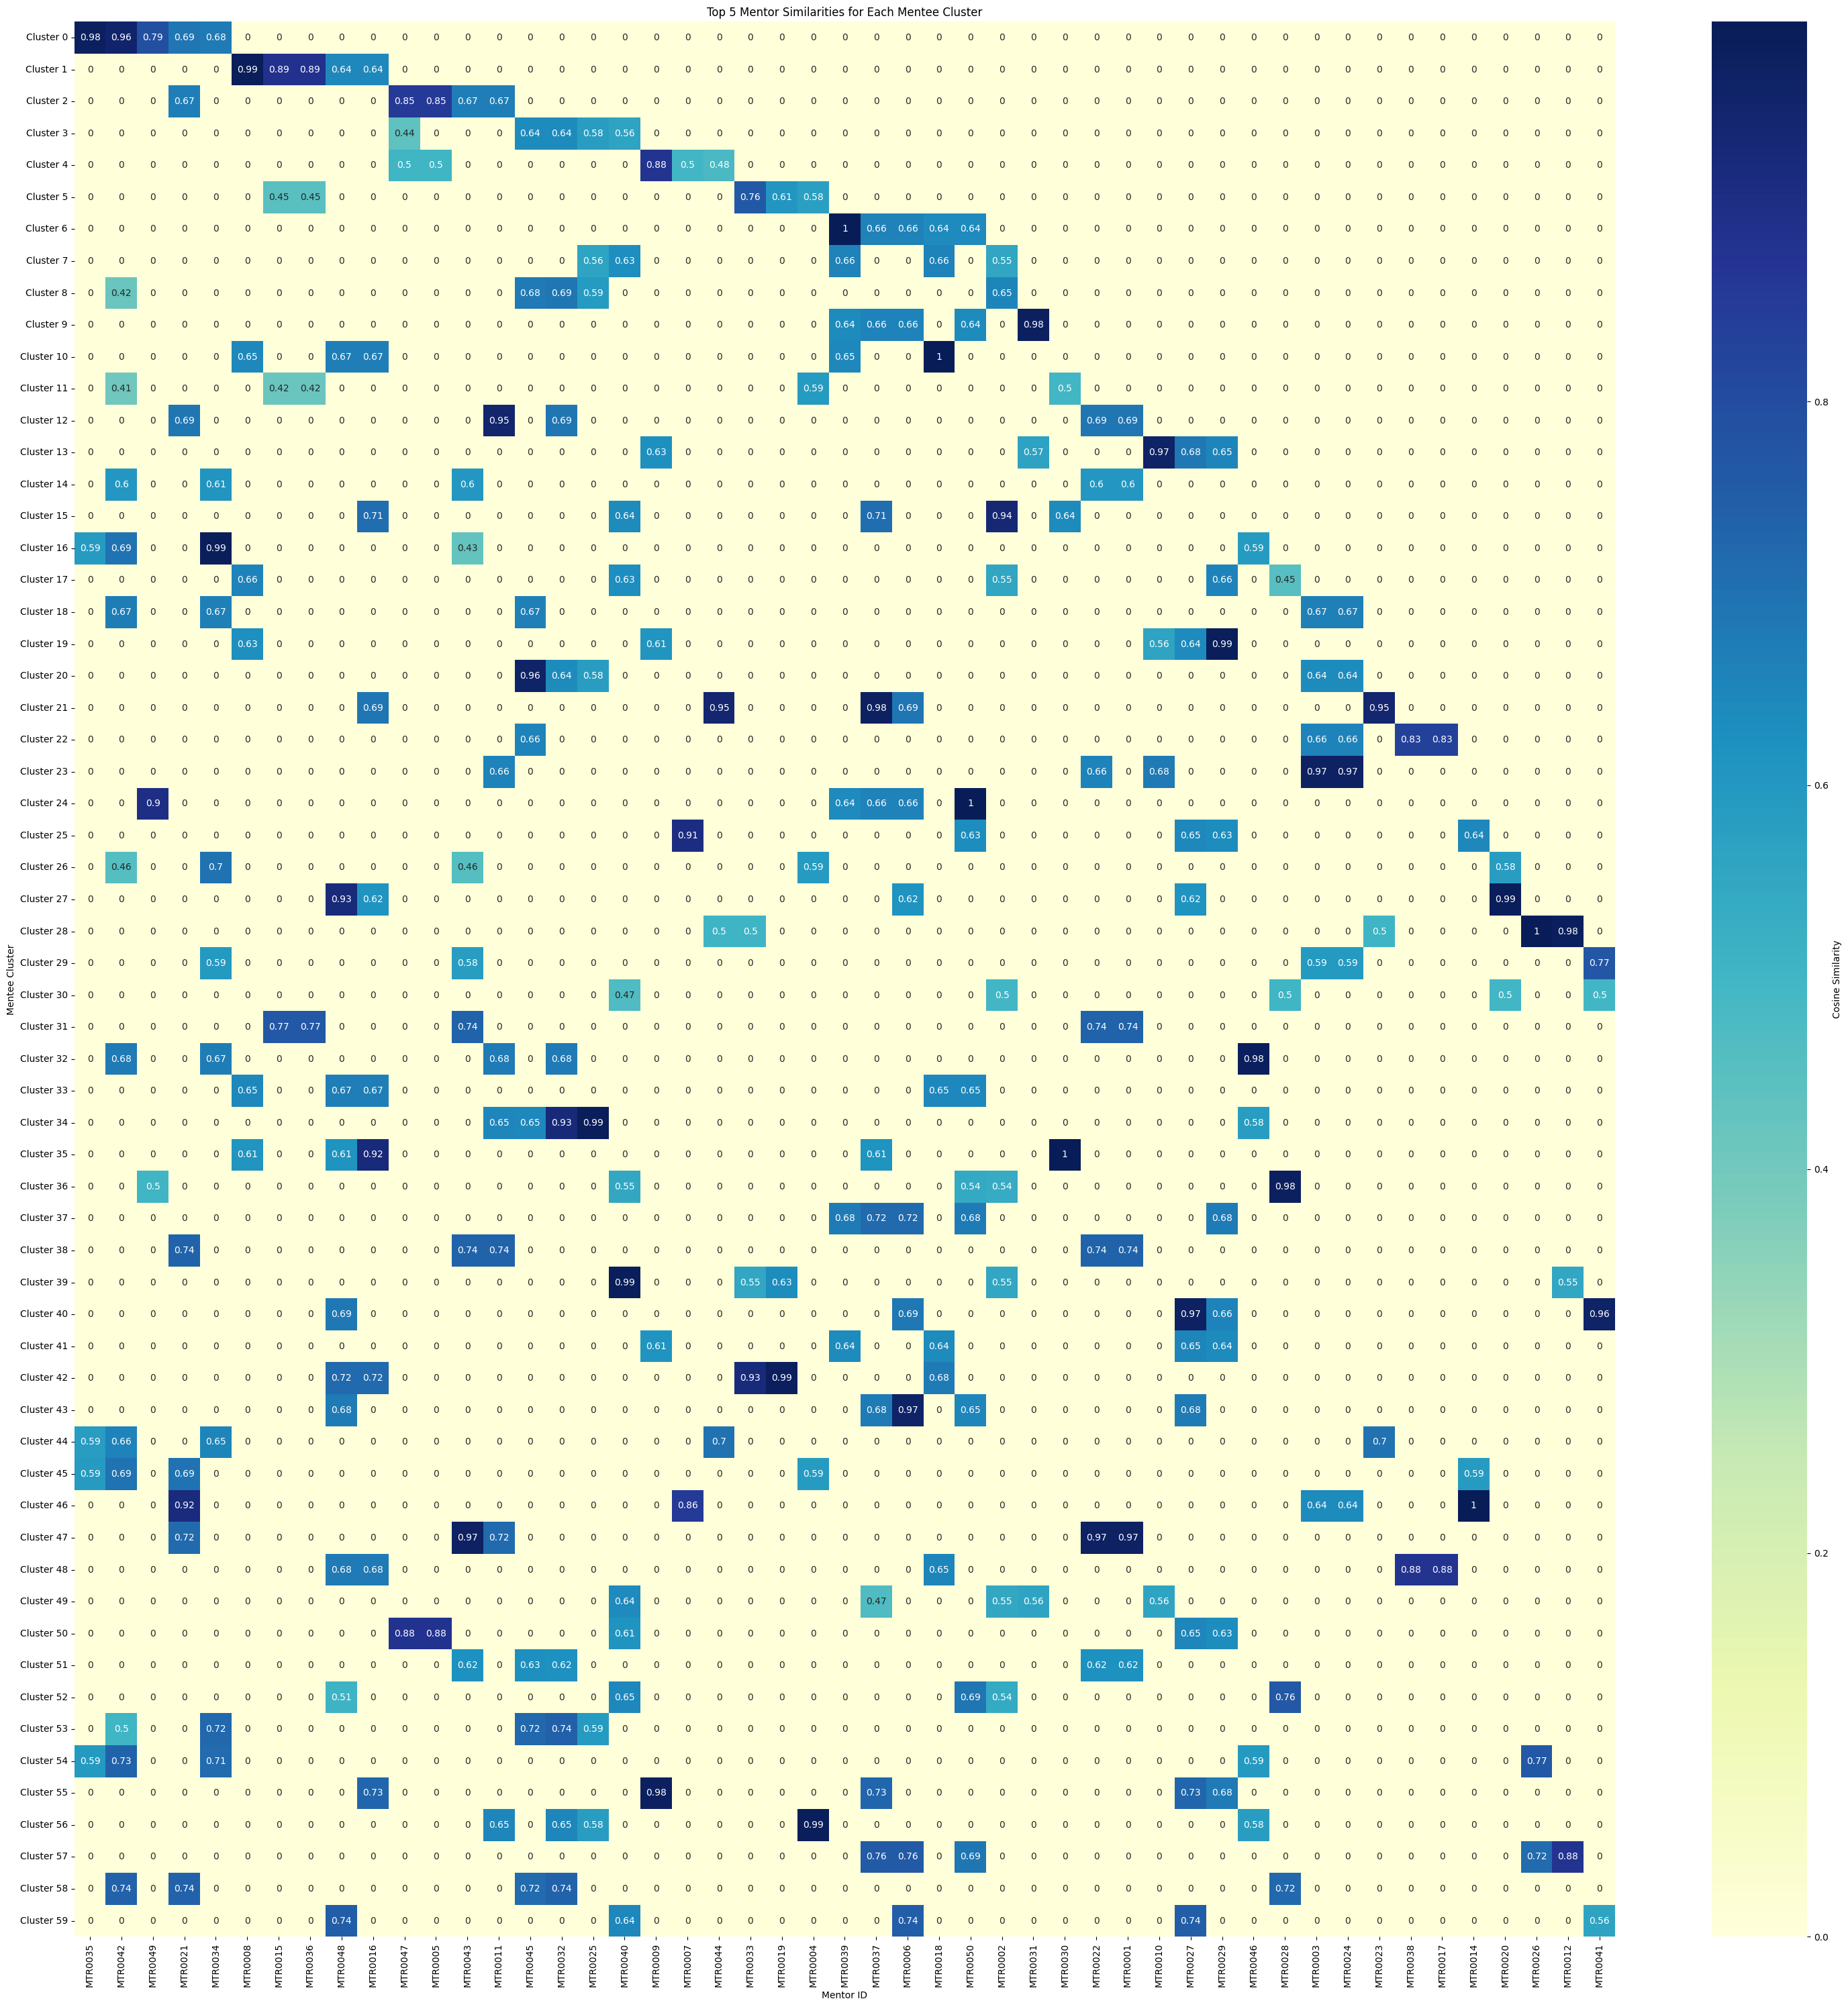

In [15]:

heatmap_data = pd.DataFrame()
for cluster_id in range(best_k):
    mentor_indices = top_5_mentors_per_cluster[cluster_id]
    mentor_ids = mentor_df.iloc[mentor_indices]['Mentor_ID'].astype(str).values
    similarities = similarity_matrix[cluster_id, mentor_indices]
    temp_series = pd.Series(similarities, index=mentor_ids, name=f'Cluster {cluster_id}')
    heatmap_data = pd.concat([heatmap_data, temp_series.to_frame().T], axis=0)

heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(30, max(6, best_k * 0.5)))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Top 5 Mentor Similarities for Each Mentee Cluster')
plt.xlabel('Mentor ID')
plt.ylabel('Mentee Cluster')
plt.tight_layout()
plt.show()

Visualize Mentor Similarity per Cluster using Heatmap (First two clusters)

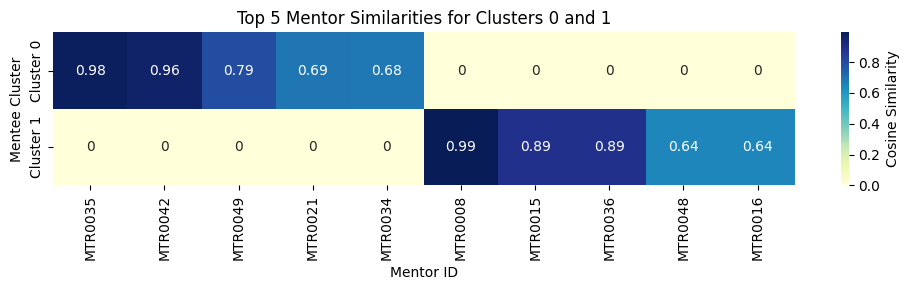

In [16]:
heatmap_data = pd.DataFrame()

# Specify the clusters you want
selected_clusters = [0, 1]

for cluster_id in selected_clusters:
    mentor_indices = top_5_mentors_per_cluster[cluster_id]
    mentor_ids = mentor_df.iloc[mentor_indices]['Mentor_ID'].astype(str).values
    similarities = similarity_matrix[cluster_id, mentor_indices]
    temp_series = pd.Series(similarities, index=mentor_ids, name=f'Cluster {cluster_id}')
    heatmap_data = pd.concat([heatmap_data, temp_series.to_frame().T], axis=0)

heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Top 5 Mentor Similarities for Clusters 0 and 1')
plt.xlabel('Mentor ID')
plt.ylabel('Mentee Cluster')
plt.tight_layout()
plt.show()


**9. Visualize using Bipartite Graph for 2 Sample Clusters**

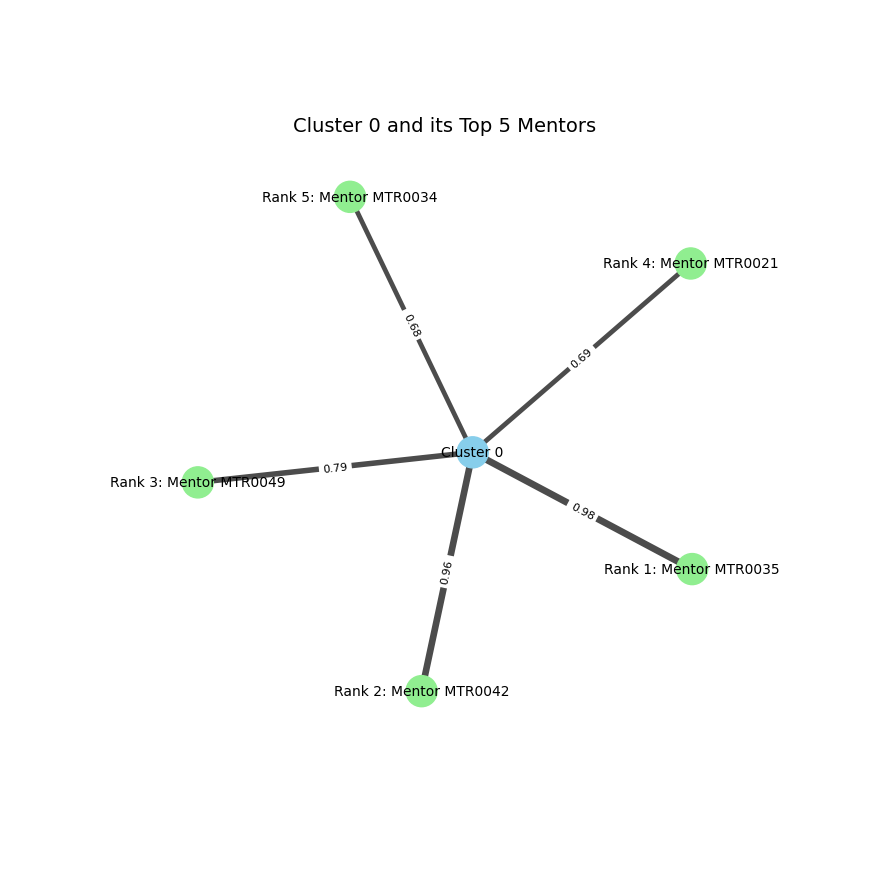

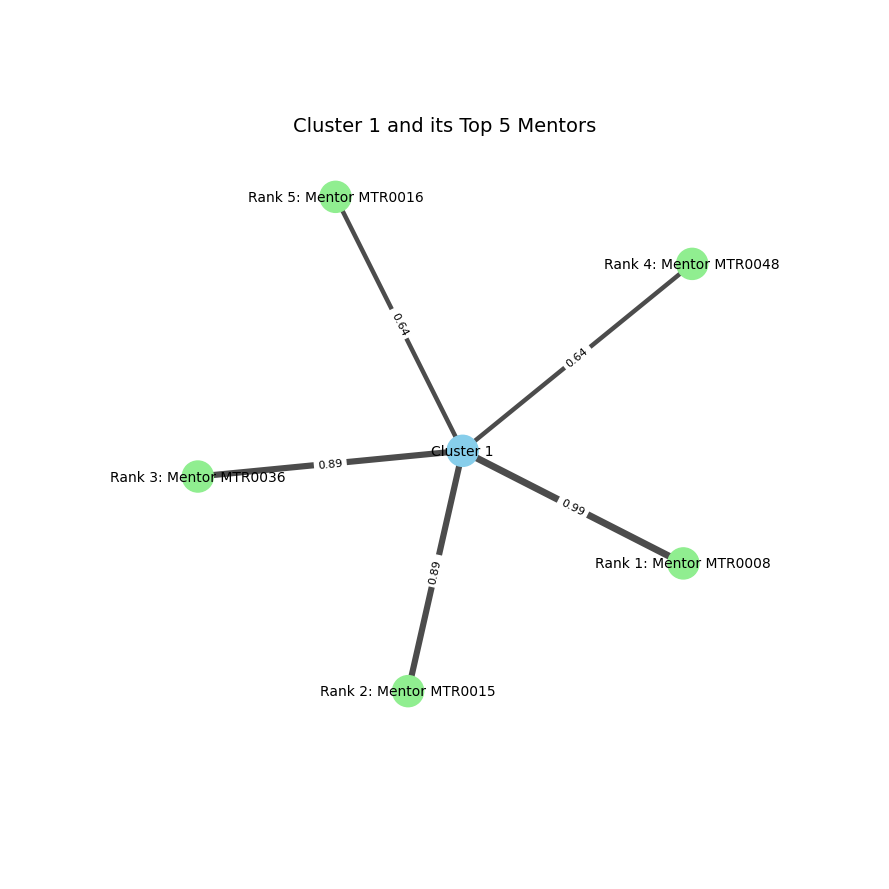

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

selected_clusters = [0, 1]  # Modify as needed

for cluster_id in selected_clusters:
    G = nx.Graph()
    
    # Add cluster node
    G.add_node(f"C{cluster_id}", label=f"Cluster {cluster_id}", bipartite=0, color='skyblue')

    # Add mentor nodes and edges
    mentor_indices = top_5_mentors_per_cluster[cluster_id]
    for rank, idx in enumerate(mentor_indices, start=1):
        mentor_id = mentor_df.iloc[idx]['Mentor_ID']
        label = f"Rank {rank}: Mentor {mentor_id}"
        node_name = f"M{mentor_id}"
        if node_name not in G:
            G.add_node(node_name, label=label, bipartite=1, color='lightgreen')
        sim = similarity_matrix[cluster_id, idx]
        G.add_edge(f"C{cluster_id}", node_name, weight=sim)

    # Improved layout and spacing
    pos = nx.spring_layout(G, seed=42, k=1.2)  # More spacing between nodes
    plt.figure(figsize=(9, 9))
    plt.margins(0.3)  # Add white space around the plot

    # Colors and weights
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    weights = [G.edges[edge]['weight'] * 5 for edge in G.edges()]
    
    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7)
    nx.draw_networkx_labels(G, pos, {n: G.nodes[n]['label'] for n in G.nodes()}, font_size=10)

    # Edge labels (similarity scores)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Cluster {cluster_id} and its Top 5 Mentors", fontsize=14, y=0.85)
    plt.axis('off')
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.savefig(f"cluster_{cluster_id}_mentors_graph.png", bbox_inches='tight', pad_inches=0.3, dpi=300)
    plt.show()
    plt.close()


In [18]:
import joblib

# Save encoders and scalers
joblib.dump(mentor_encoder, 'mentor_encoder.pkl')
joblib.dump(mentee_encoder, 'mentee_encoder.pkl')
joblib.dump(StandardScaler().fit(mentor_df[numerical_mentors]), 'mentor_scaler.pkl')
joblib.dump(StandardScaler().fit(mentee_df[numerical_mentees]), 'mentee_scaler.pkl')

# Save KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Save cluster centroids and mentor embeddings
np.save('cluster_centroids.npy', cluster_centroids)
np.save('X_mentors.npy', X_mentors)

# (Optional) Save mentor_df with IDs
mentor_df.to_csv('mentor_df.csv', index=False)



In [19]:
import joblib
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load artifacts
mentor_encoder = joblib.load('mentor_encoder.pkl')
mentee_encoder = joblib.load('mentee_encoder.pkl')
mentor_scaler = joblib.load('mentor_scaler.pkl')
mentee_scaler = joblib.load('mentee_scaler.pkl')
kmeans = joblib.load('kmeans_model.pkl')
cluster_centroids = np.load('cluster_centroids.npy')
X_mentors = np.load('X_mentors.npy')
mentor_df = pd.read_csv('mentor_df.csv')

def match_mentee_to_mentors(mentee_input: dict):
    """
    mentee_input: dict with same keys as the features you used.
    Example: 
    {
      'Mentee_BurnoutRiskScore': 50,
      'Mentee_InterestField': 'AI',
      'Mentee_Location': 'Denmark'
    }
    """
    # 1. Encode and scale
    cat_features = mentee_encoder.transform([[mentee_input['Mentee_InterestField'], mentee_input['Mentee_Location']]])
    num_features = mentee_scaler.transform([[mentee_input['Mentee_BurnoutRiskScore']]])
    mentee_vector = np.hstack([num_features, cat_features])

    # 2. Predict cluster
    cluster_id = kmeans.predict([mentee_vector])[0]

    # 3. Compute similarity with mentors
    cluster_center = cluster_centroids[cluster_id].reshape(1, -1)
    similarities = cosine_similarity(cluster_center, X_mentors)[0]
    top_indices = similarities.argsort()[-5:][::-1]

    top_mentors = []
    for idx in top_indices:
        mentor_id = mentor_df.iloc[idx]['Mentor_ID']
        similarity = similarities[idx]
        top_mentors.append({'Mentor_ID': mentor_id, 'Similarity': similarity})

    return {'Cluster': cluster_id, 'Top_Mentors': top_mentors}
